In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, classification_report, RocCurveDisplay
from scipy.stats import ks_2samp
from optuna.study import MaxTrialsCallback
from optuna import create_study
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from optuna.trial import TrialState
from functools import partial
import optuna
from xgboost import XGBClassifier
import shap 

shap.initjs()
optuna.logging.set_verbosity(optuna.logging.WARNING)

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

%env PYTHONHASHSEED 0

env: PYTHONHASHSEED=0


# Reading In and Merging Data

In [2]:
app_data = pd.read_excel('Homework_Data_Scientist.xlsx', engine='openpyxl', sheet_name='Application Data', parse_dates=['birth_date', 'application_when'])
loan_performance = pd.read_excel('Homework_Data_Scientist.xlsx', engine='openpyxl', sheet_name='Loan Performance')
loan_performance['customer_id'] = loan_performance.idLoan.str.split('-').str[0].str.lower()
data = app_data.merge(loan_performance, on = ['customer_id'])
print(f"Dataset Dimensions: {data.shape}")

Dataset Dimensions: (650, 33)


Initial Comments: 

- small volume of data --> may be better to use simplier models and fewer, simplier features 
- Classification task -> metrics: accuracy if balanced F1-score if unbalanced, report AUC
- Assumptions: samples are independent (i.e., probability that one person defaults is independent of another person defaulting)
- Data Set: No repeat customer history (once default good indicator of future), no macro-economic factors included,  narrow timeframe, no data dictionary

# Data Cleaning

### NaN Values

In [3]:
na_vals = data.isna()
na_cols = data.columns[data.isna().any()]
display(pd.DataFrame(zip(na_vals[na_cols].sum(), na_vals[na_cols].mean()),columns=['nan_count', 'proportion_nan'], index=na_cols).sort_values('nan_count'))

# bank_account_duration: nan because payment_ach = 0 (additional context required on payment_ach and bank_account_duration fields), since only 1 row will drop
data = data[data.bank_account_duration.notnull()]

# how_use_money: dropping nan for bank_account_duration dropped 1 out of 2 how_use_money nan rows; since only 1 row will drop (could have absorbed into "Other" cateogory)
data = data[data.how_use_money.notnull()]

# payment_amount_approved: couldn't determine cause of missing data; sample from ratio between payment_amount and payment_amount_approved to impute values 
payment_ratios = (data['payment_amount_approved'] / data['payment_amount']).dropna()
data.loc[data.payment_amount_approved.isna(), 'payment_amount_approved'] = data.loc[data.payment_amount_approved.isna(), 'payment_amount'].apply(lambda v: round(v * payment_ratios.sample().values[0], 2))

# other_phone_type: not an important feature, will drop feature
data.drop('other_phone_type', axis=1, inplace=True)

,nan_count,proportion_nan
bank_account_duration,1,0.001538
how_use_money,2,0.003077
payment_amount_approved,22,0.033846
other_phone_type,291,0.447692


### Handle Boolean Values (and flgGood)

In [4]:
bool_cols = data.select_dtypes('bool').columns
print(f"Bool Features:\n{', '.join(list(bool_cols))}")
data[bool_cols] = data[bool_cols].astype(int)
data['flgGood'] = data['flgGood'].map({'Good': 1, 'Bad': 0})

Bool Features:
residence_rent_or_own, bank_account_direct_deposit, payment_ach


### Data Type Casting

In [5]:
# Zip code, bank routing number are numeric representations of categorical features
data['address_zip'] = data['address_zip'].astype(str)
data['bank_routing_number'] = data['bank_routing_number'].astype(str)

### FICO/L2C Score Filtering

In [6]:
# Scores should be in range [300, 850]; filter out any rows where fico scores are outside of this range
data = data[(data[[c for c in data.columns if 'FICO' in c]] > 300).all(axis=1) & (data[[c for c in data.columns if 'FICO' in c]] < 850).all(axis=1) & (data['raw_l2c_score'] > 300) & (data['raw_l2c_score'] < 850)].reset_index(drop=True)

Data set was already fairly clean - additional cleaning steps not necessary (i.e., deduplication, text processing, etc.) 

# Initial EDA 

### Object Data Types

In [7]:
print(f"Object Data Types:\n{', '.join(list(data.select_dtypes(object).columns))}")

Object Data Types:
customer_id, status, address_zip, email, bank_routing_number, email_duration, residence_duration, bank_account_duration, payment_frequency, home_phone_type, how_use_money, idLoan


In [8]:
# customer_id - unique identifier (can drop)
display(data['customer_id'].value_counts(normalize=True))
data.drop('customer_id', axis=1, inplace=True)

70409dc892    0.003226
a15e74274b    0.003226
4dad1a9de6    0.003226
d7001aa34e    0.003226
2ac47a61e0    0.003226
                ...   
bfbe8605a7    0.001613
fdad7630df    0.001613
08a3e0ca08    0.001613
ee1d1531f0    0.001613
d42be20081    0.001613
Name: customer_id, Length: 606, dtype: float64

In [9]:
# status - all 1s, can drop as all rows are approved loans
display(data['status'].value_counts(normalize=True))
data.drop('status', axis=1, inplace=True)

Approved    1.0
Name: status, dtype: float64

In [10]:
# address_zip - broader locations can be identified by first 2 zip code digits, potentially perform this stripping
display(data['address_zip'].value_counts(normalize=True))
data.groupby('address_zip')['flgGood'].agg(['mean', 'count'])

84120    0.027419
84118    0.024194
84047    0.024194
84404    0.024194
84119    0.022581
           ...   
84087    0.001613
57013    0.001613
57073    0.001613
84639    0.001613
83211    0.001613
Name: address_zip, Length: 193, dtype: float64

,mean,count
address_zip,,
57003,0.00,1
57013,1.00,1
57018,1.00,1
57022,0.00,1
57032,0.00,1
...,...,...
84754,1.00,1
84767,1.00,1
84770,0.25,4


In [11]:
# email - connected to unique customer, highest frequency is 2, can drop as no information provided
display(data['email'].value_counts(normalize=True))
data.drop('email', axis=1, inplace=True)

JohnSRoyston@gmail.com         0.003226
CaroleLWhite@aol.com           0.003226
MonicaCHerbert@gmail.com       0.003226
RogerMVermillion@bing.com      0.003226
EricMHernandez@bing.com        0.003226
                                 ...   
LauraTPinion@aol.com           0.001613
RuthDTillman@bing.com          0.001613
KariJReece@bing.com            0.001613
StephenSRedmond@hotmail.com    0.001613
VernonPDiaz@aol.com            0.001613
Name: email, Length: 606, dtype: float64

In [12]:
# bank_routing_number - may need to create default "Other" bank routing number
display(data['bank_routing_number'].value_counts(normalize=True))
data.groupby('bank_routing_number')['flgGood'].agg(['mean', 'count'])

124002971    0.119355
124001545    0.109677
324377516    0.085484
124000054    0.059677
124302150    0.051613
               ...   
91400486     0.001613
91402947     0.001613
324173710    0.001613
291070001    0.001613
124302930    0.001613
Name: bank_routing_number, Length: 130, dtype: float64

,mean,count
bank_routing_number,,
101089742,1.000000,2
102000076,0.000000,1
102301092,0.000000,1
103101437,0.000000,1
107002192,0.000000,1
...,...,...
91408501,0.200000,5
91408598,0.500000,2
91408734,0.363636,11


In [13]:
# email_duration - may be valueable feature (will look at this during multivariate eda), feature engineering idea= aggregate into 0-12 months or remove
display(data['email_duration'].value_counts(normalize=True))
data.groupby('email_duration')['flgGood'].agg(['mean', 'count'])

1 year or more      0.917742
4-12 months         0.056452
3 months or less    0.025806
Name: email_duration, dtype: float64

,mean,count
email_duration,,
1 year or more,0.442882,569
3 months or less,0.562500,16
4-12 months,0.457143,35


In [14]:
# residence_duration - may be valueable feature (will look at this during multivariate eda), feature engineering idea= aggregate into 0-12 months 
display(data['residence_duration'].value_counts(normalize=True))
data.groupby('residence_duration')['flgGood'].agg(['mean', 'count'])

3+ years            0.587097
1-2 years           0.187097
6 months or less    0.116129
7-12 months         0.109677
Name: residence_duration, dtype: float64

,mean,count
residence_duration,,
1-2 years,0.413793,116
3+ years,0.475275,364
6 months or less,0.458333,72
7-12 months,0.338235,68


In [15]:
# bank_account_duration - may be valueable feature (will look at this during multivariate eda), feature engineering idea= aggregate into 0-12 months 
display(data['bank_account_duration'].value_counts(normalize=True))
data.groupby('bank_account_duration')['flgGood'].agg(['mean', 'count'])

3+ years            0.503226
1-2 years           0.204839
6 months or less    0.201613
7-12 months         0.090323
Name: bank_account_duration, dtype: float64

,mean,count
bank_account_duration,,
1-2 years,0.401575,127
3+ years,0.493590,312
6 months or less,0.352000,125
7-12 months,0.500000,56


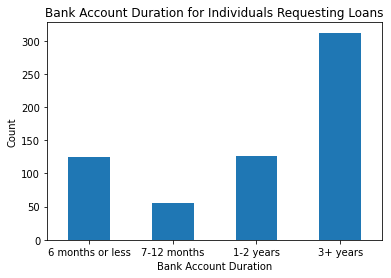

In [16]:
ax = data['bank_account_duration'].value_counts().loc[['6 months or less', '7-12 months', '1-2 years', '3+ years']].plot.bar()
plt.title('Bank Account Duration for Individuals Requesting Loans');
plt.xlabel("Bank Account Duration")
plt.ylabel("Count")
plt.xticks(rotation=0, ha='center')
ax.figure.savefig('bank_account_dur_hist.png', dpi=300)

In [17]:
# payment_frequency - may be valueable feature (will look at this during multivariate eda)
display(data['payment_frequency'].value_counts(normalize=True))
data.groupby('payment_frequency')['flgGood'].agg(['mean', 'count'])

Bi-weekly       0.509677
Monthly         0.264516
Semi-monthly    0.182258
Weekly          0.043548
Name: payment_frequency, dtype: float64

,mean,count
payment_frequency,,
Bi-weekly,0.363924,316
Monthly,0.548780,164
Semi-monthly,0.592920,113
Weekly,0.185185,27


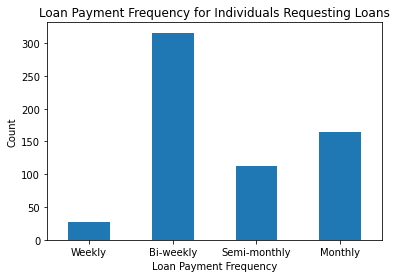

In [18]:
ax = data['payment_frequency'].value_counts().loc[['Weekly', 'Bi-weekly', 'Semi-monthly', 'Monthly']].plot.bar()
plt.title("Loan Payment Frequency for Individuals Requesting Loans");
plt.xlabel("Loan Payment Frequency")
plt.ylabel("Count")
plt.xticks(rotation=0, ha='center')
ax.figure.savefig('payment_freq_hist.png', dpi=300)

In [19]:
# home_phone_type - logically this seems like an unimportant feature to predict loan quality- drop feature
display(data['home_phone_type'].value_counts(normalize=True))
data.drop('home_phone_type', axis=1, inplace=True)

Mobile    0.822581
Home      0.161290
Work      0.016129
Name: home_phone_type, dtype: float64

In [20]:
# how_use_money - too many individual categories, 'Other' not descriptive, drop feature due to little information able to be extracted
display(data['how_use_money'].value_counts(normalize=True))
data.groupby('how_use_money')['flgGood'].agg(['mean', 'count'])
data.drop('how_use_money', axis=1, inplace=True)

Other                             0.530645
Bills (General)                   0.125806
Bills                             0.090323
Bills (Auto)                      0.074194
Car                               0.046774
Bills (Medical)                   0.046774
Bills (Home / Utilities)          0.025806
Pay off loans / overdrawn acct    0.017742
Medical                           0.014516
School                            0.008065
Rent                              0.006452
Rent / Mortgage                   0.006452
Gifts / Leisure                   0.004839
Won't say                         0.001613
Name: how_use_money, dtype: float64

In [21]:
# idLoan - unique loan identifier (can drop)
display(data['idLoan'].value_counts(normalize=True))
data.drop('idLoan', axis=1, inplace=True)

9ECE67D6C5-01    0.001613
854656E5AE-01    0.001613
4F9832AB95-01    0.001613
4C203DCE81-01    0.001613
DD33DA2634-01    0.001613
                   ...   
EE90CB8777-01    0.001613
8AD3AC65B0-01    0.001613
D9D72A6C02-01    0.001613
1290D18BD2-01    0.001613
D42BE20081-01    0.001613
Name: idLoan, Length: 620, dtype: float64

### Int Data Types


In [22]:
print(f"Object Data Types:\n{', '.join(list(data.select_dtypes([int, float]).columns))}")

Object Data Types:
amount_requested, residence_rent_or_own, monthly_rent_amount, bank_account_direct_deposit, loan_duration, payment_ach, num_payments, payment_amount, amount_approved, duration_approved, payment_amount_approved, monthly_income_amount, raw_l2c_score, raw_FICO_telecom, raw_FICO_retail, raw_FICO_bank_card, raw_FICO_money, flgGood


500    0.367742
800    0.340323
300    0.085484
600    0.074194
400    0.070968
700    0.056452
550    0.001613
750    0.001613
350    0.001613
Name: amount_requested, dtype: float64

,mean,count
amount_requested,,
300,0.660377,53
400,0.444444,45
500,0.429825,228
600,0.382979,47
700,0.400000,35
800,0.433962,212


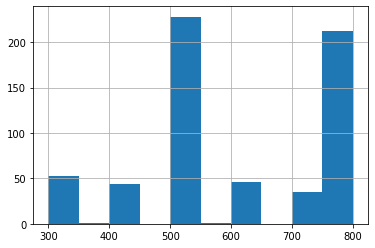

In [23]:
# amount_requested - feature engineering round up to nearest 100
display(data['amount_requested'].value_counts(normalize=True))
data['amount_requested'].hist(bins=10);

data['amount_requested'] = data['amount_requested'].apply(lambda v: ((v + 50) // 100) * 100)
data.groupby('amount_requested')['flgGood'].agg(['mean', 'count'])

1    0.672581
0    0.327419
Name: residence_rent_or_own, dtype: float64

,mean,count
residence_rent_or_own,,
0,0.517241,203
1,0.412470,417


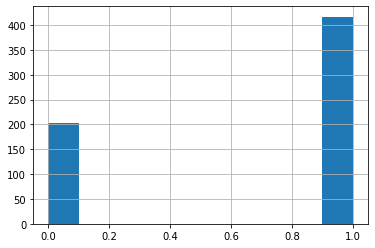

In [24]:
# residence_rent_or_own- binary feature (good variation) 
display(data['residence_rent_or_own'].value_counts(normalize=True))
data['residence_rent_or_own'].hist(bins=10);
data.groupby('residence_rent_or_own')['flgGood'].agg(['mean', 'count'])

0       0.156452
400     0.045161
500     0.038710
750     0.027419
600     0.027419
          ...   
1900    0.001613
517     0.001613
1309    0.001613
603     0.001613
529     0.001613
Name: monthly_rent_amount, Length: 192, dtype: float64

<Axes: xlabel='monthly_rent_amount', ylabel='flgGood'>

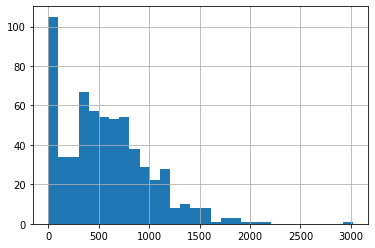

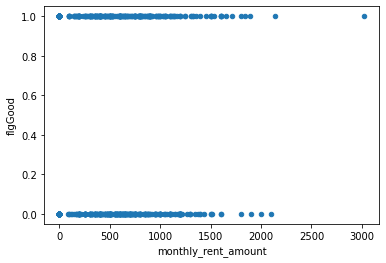

In [25]:
# monthly_rent_amount - large amount of 0 rents, assume this is because they don't rent, don't use feature directly, can aggregate with income to say "income after rent"
display(data['monthly_rent_amount'].value_counts(normalize=True))
data['monthly_rent_amount'].hist(bins=30);

data.plot.scatter(x = 'monthly_rent_amount', y='flgGood')

1    0.814516
0    0.185484
Name: bank_account_direct_deposit, dtype: float64

,mean,count
bank_account_direct_deposit,,
0,0.391304,115
1,0.459406,505


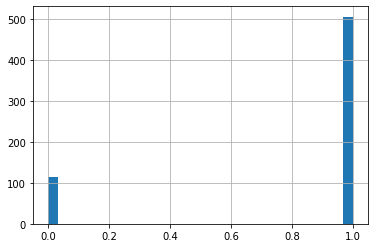

In [26]:
# bank_account_direct_deposit - background context would help to understand if direct deposit is practically relevant (naively not sure), will analyze further in multivariate
display(data['bank_account_direct_deposit'].value_counts(normalize=True))
data['bank_account_direct_deposit'].hist(bins=30);
data.groupby('bank_account_direct_deposit')['flgGood'].agg(['mean', 'count'])

5    0.403226
8    0.300000
6    0.167742
3    0.072581
4    0.040323
7    0.014516
2    0.001613
Name: loan_duration, dtype: float64

,mean,count
loan_duration,,
2,0.000000,1
3,0.577778,45
4,0.360000,25
5,0.420000,250
6,0.480769,104
7,0.333333,9
8,0.451613,186


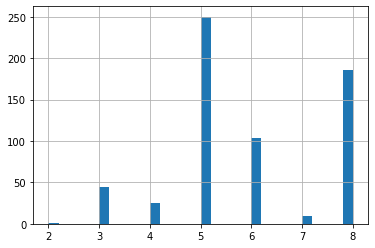

In [27]:
# loan_duration
display(data['loan_duration'].value_counts(normalize=True))
data['loan_duration'].hist(bins=30);

data.groupby('loan_duration')['flgGood'].agg(['mean', 'count'])

1    1.0
Name: payment_ach, dtype: float64

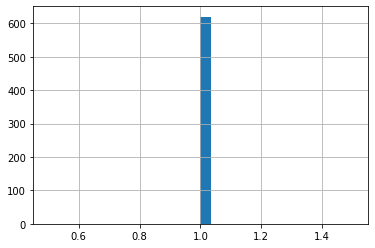

In [28]:
# payment_ach - all 1s payment ach can be dropped
display(data['payment_ach'].value_counts(normalize=True))
data['payment_ach'].hist(bins=30);

data.drop('payment_ach', axis=1, inplace=True)

10    0.264516
13    0.203226
6     0.124194
5     0.114516
12    0.077419
8     0.069355
17    0.054839
21    0.024194
16    0.020968
3     0.016129
4     0.014516
26    0.008065
15    0.004839
34    0.001613
7     0.001613
Name: num_payments, dtype: float64

,mean,count
num_payments,,
3,0.800000,10
4,0.666667,9
5,0.633803,71
6,0.428571,77
7,1.000000,1
8,0.395349,43
10,0.347561,164
12,0.645833,48
13,0.388889,126


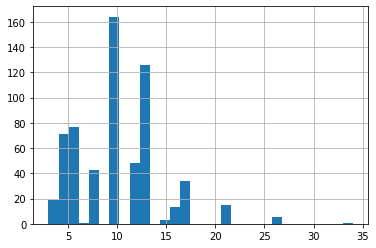

In [29]:
# num_payments
display(data['num_payments'].value_counts(normalize=True))
data['num_payments'].hist(bins=30);

data.groupby('num_payments')['flgGood'].agg(['mean', 'count'])

500    0.648387
800    0.143548
300    0.085484
400    0.070968
700    0.025806
600    0.024194
350    0.001613
Name: amount_approved, dtype: float64

,mean,count
amount_approved,,
300,0.660377,53
400,0.444444,45
500,0.398010,402
600,0.266667,15
700,0.437500,16
800,0.573034,89


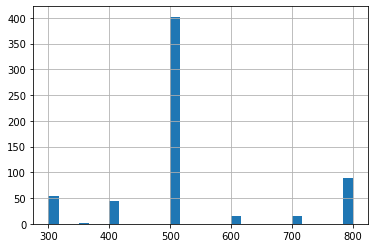

In [30]:
# amount_approved - round up to nearest 100
display(data['amount_approved'].value_counts(normalize=True))
data['amount_approved'].hist(bins=30);

data['amount_approved'] = data['amount_approved'].apply(lambda v: ((v + 50) // 100) * 100)

data.groupby('amount_approved')['flgGood'].agg(['mean', 'count'])

5    0.403226
6    0.356452
8    0.119355
3    0.072581
4    0.040323
7    0.006452
2    0.001613
Name: duration_approved, dtype: float64

,mean,count
duration_approved,,
2,0.000000,1
3,0.577778,45
4,0.360000,25
5,0.420000,250
6,0.429864,221
7,0.500000,4
8,0.540541,74


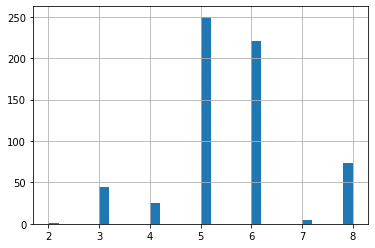

In [31]:
# duration_approved 
display(data['duration_approved'].value_counts(normalize=True))
data['duration_approved'].hist(bins=30);

data.groupby('duration_approved')['flgGood'].agg(['mean', 'count'])

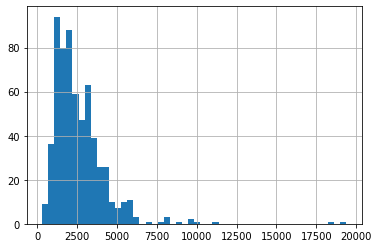

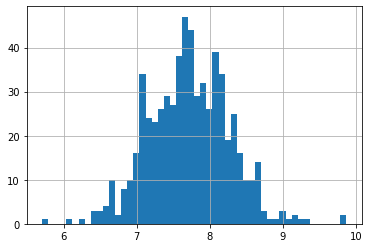

<Axes: xlabel='monthly_income_amount', ylabel='flgGood'>

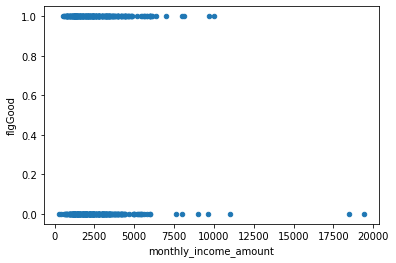

In [32]:
# monthly_income_amount- lognormal distribution
data['monthly_income_amount'].hist(bins=50)
plt.show()
data['monthly_income_amount'].apply(np.log).hist(bins=50)
plt.show()

data.plot.scatter(x = 'monthly_income_amount', y='flgGood')

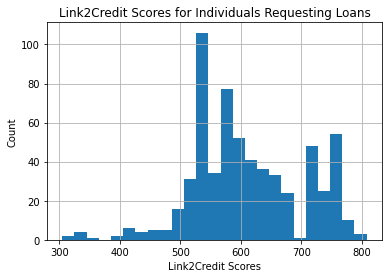

In [33]:
ax = data['raw_l2c_score'].hist(bins=25)
plt.title("Link2Credit Scores for Individuals Requesting Loans");
plt.xlabel("Link2Credit Scores")
plt.ylabel("Count")
plt.xticks(rotation=0, ha='center')
ax.figure.savefig('l2c_hist.png', dpi=300)

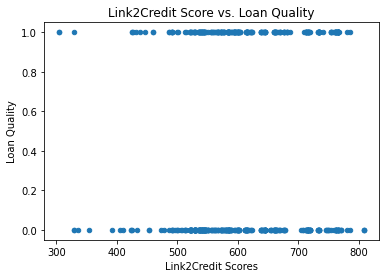

In [34]:
ax = data.plot.scatter(x = 'raw_l2c_score', y='flgGood')
plt.title("Link2Credit Score vs. Loan Quality");
plt.xlabel("Link2Credit Scores")
plt.ylabel("Loan Quality")
plt.xticks(rotation=0, ha='center')
ax.figure.savefig('l2c_lq_hist.png', dpi=300)

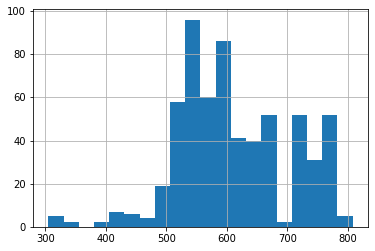

<Axes: xlabel='raw_l2c_score', ylabel='flgGood'>

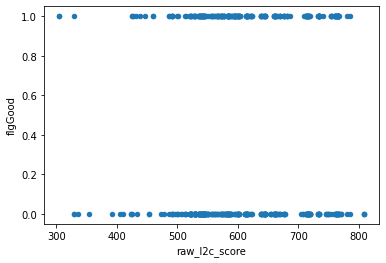

In [35]:
# raw_l2c_score - right skew normal dist (roughly)
data['raw_l2c_score'].hist(bins=20)
plt.show()

data.plot.scatter(x = 'raw_l2c_score', y='flgGood')

<Axes: xlabel='raw_FICO_telecom', ylabel='flgGood'>

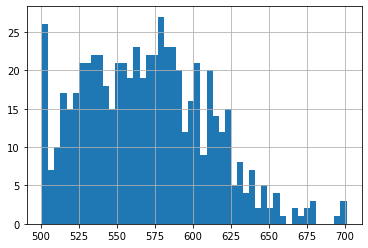

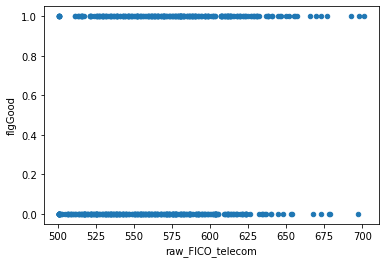

In [36]:
# raw_FICO_telecom - normal dist with 500 min cut off
data['raw_FICO_telecom'].hist(bins=50);

data.plot.scatter(x = 'raw_FICO_telecom', y='flgGood')

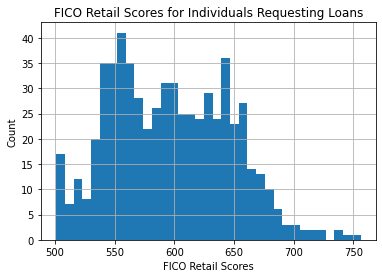

In [37]:
ax = data['raw_FICO_retail'].hist(bins=35)
plt.title("FICO Retail Scores for Individuals Requesting Loans");
plt.xlabel("FICO Retail Scores")
plt.ylabel("Count")
plt.xticks(rotation=0, ha='center')
ax.figure.savefig('fico_retail_hist.png', dpi=300)

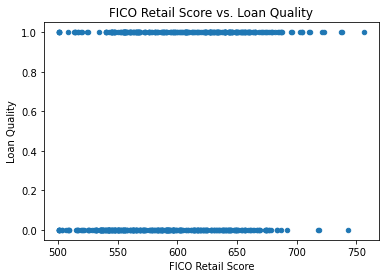

In [38]:
ax = data.plot.scatter(x = 'raw_FICO_retail', y='flgGood')
plt.title("FICO Retail Score vs. Loan Quality");
plt.xlabel("FICO Retail Score")
plt.ylabel("Loan Quality")
plt.xticks(rotation=0, ha='center')
ax.figure.savefig('fico_retail_lq_hist.png', dpi=300)

<Axes: xlabel='raw_FICO_retail', ylabel='flgGood'>

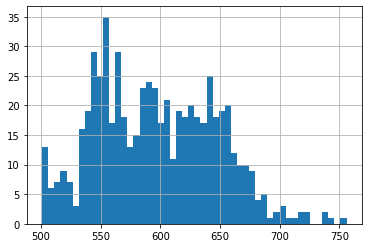

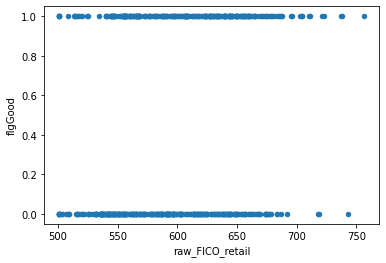

In [39]:
# raw_FICO_retail  - multimodal dist
data['raw_FICO_retail'].hist(bins=50);
data.plot.scatter(x = 'raw_FICO_retail', y='flgGood')

<Axes: xlabel='raw_FICO_bank_card', ylabel='flgGood'>

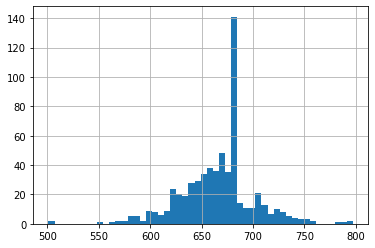

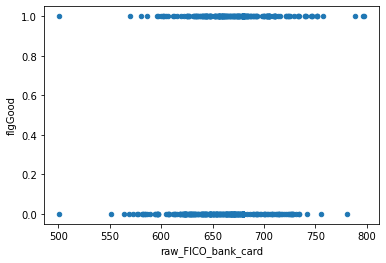

In [40]:
# raw_FICO_bank_card - normal dist
data['raw_FICO_bank_card'].hist(bins=50);
data.plot.scatter(x = 'raw_FICO_bank_card', y='flgGood')

<Axes: xlabel='raw_FICO_money', ylabel='flgGood'>

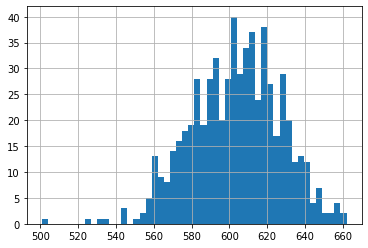

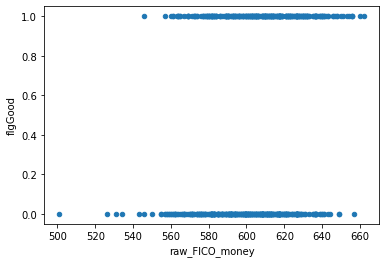

In [41]:
# raw_FICO_money  - normal dist
data['raw_FICO_money'].hist(bins=50);
data.plot.scatter(x = 'raw_FICO_money', y='flgGood')

<Axes: xlabel='payment_amount', ylabel='flgGood'>

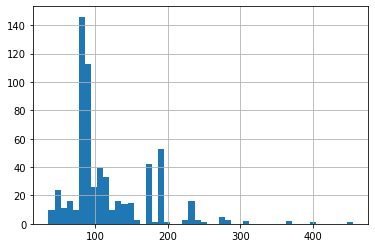

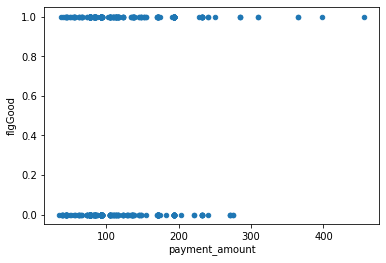

In [42]:
# payment_amount  - appears to have high correlation with payment_amount
data['payment_amount'].hist(bins=50);
data.plot.scatter(x = 'payment_amount', y='flgGood')

<Axes: xlabel='payment_amount_approved', ylabel='flgGood'>

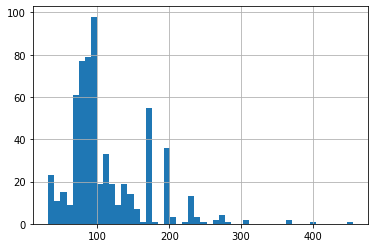

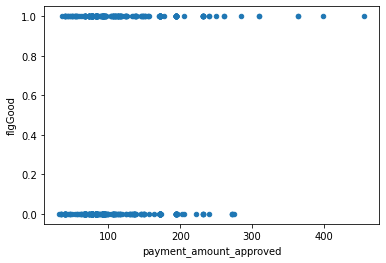

In [43]:
# payment_amount_approved  - appears to have high correlation with payment_amount
data['payment_amount_approved'].hist(bins=50);
data.plot.scatter(x = 'payment_amount_approved', y='flgGood')

### Target Variable 

In [44]:
# fairly evenly balanced
data['flgGood'].value_counts(normalize=True)

0    0.553226
1    0.446774
Name: flgGood, dtype: float64

# Feature Engineering

In [45]:
# Zip code to encode only 2 digits 
print(data['address_zip'].nunique())
data['address_zip'] = data['address_zip'].str[:2]
data.groupby('address_zip')['flgGood'].agg(['mean', 'count'])
print(data['address_zip'].nunique())

193
3


In [46]:
# Bank Routing number - create "Other" denomination for low-volume bank_routing_numbers
print(data['bank_routing_number'].nunique())
bank_rn_vc = data['bank_routing_number'].value_counts()
bank_rn_retain = bank_rn_vc[bank_rn_vc>=15].index
data['bank_routing_number'] = data['bank_routing_number'].apply(lambda rn: rn if rn in bank_rn_retain else 'default')
data.groupby('bank_routing_number')['flgGood'].agg(['mean', 'count'])
print(data['bank_routing_number'].nunique())

130
9


In [47]:
# email_duration
data['email_duration'] = data['email_duration'].apply(lambda v: v if v == '1 year or more' else '0-12 months')
data.groupby('email_duration')['flgGood'].agg(['mean', 'count'])

,mean,count
email_duration,,
0-12 months,0.490196,51
1 year or more,0.442882,569


In [48]:
# residence duration 
display(data['residence_duration'].value_counts(normalize=True))
data['residence_duration'] = data['residence_duration'].apply(lambda v: v if v in ['1-2 years', '3+ years'] else '0-12 months')
data.groupby('residence_duration')['flgGood'].agg(['mean', 'count'])

3+ years            0.587097
1-2 years           0.187097
6 months or less    0.116129
7-12 months         0.109677
Name: residence_duration, dtype: float64

,mean,count
residence_duration,,
0-12 months,0.400000,140
1-2 years,0.413793,116
3+ years,0.475275,364


In [49]:
# bank_account_duration
data['bank_account_duration'] = data['bank_account_duration'].apply(lambda v: v if v in ['1-2 years', '3+ years'] else '0-12 months')
data.groupby('bank_account_duration')['flgGood'].agg(['mean', 'count'])

,mean,count
bank_account_duration,,
0-12 months,0.397790,181
1-2 years,0.401575,127
3+ years,0.493590,312


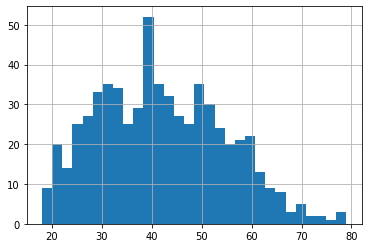

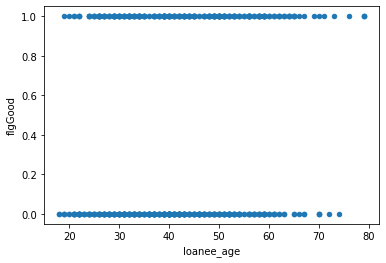

In [50]:
# Birth_date feature extraction
data['loanee_age'] = (data['application_when'] -  data['birth_date']).astype('timedelta64[Y]').astype(int)
data['loanee_age'].hist(bins=30);

data.plot.scatter(x = 'loanee_age', y='flgGood')

data.drop('birth_date', axis=1, inplace=True)

pays_rent
0    0.402062
1    0.455067
Name: flgGood, dtype: float64

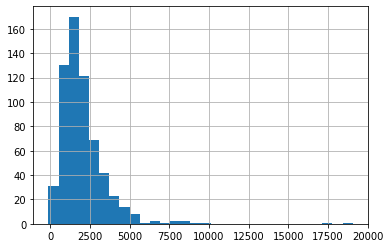

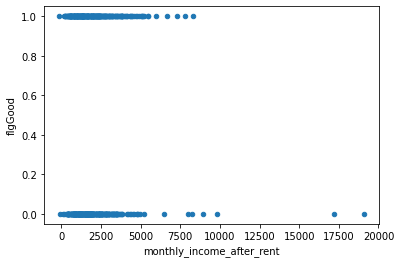

In [51]:
# Since monthly_rent_amount can be 0, devise feature that takes into account this, utilize monthly_income_after_rent instead of monthly_income_amount and monthly_rent_amount
data['monthly_income_after_rent'] = data['monthly_income_amount'] - data['monthly_rent_amount']
data['pays_rent'] = data['monthly_rent_amount'].apply(lambda v: 0 if v == 0 else 1)
data['monthly_income_after_rent'].hist(bins=30);

data.plot.scatter(x = 'monthly_income_after_rent', y='flgGood');
display(data.groupby('pays_rent')['flgGood'].mean())

In [52]:
# Produce sample weights based on time
data['year_month'] = data['application_when'].dt.year.astype(str) + '_' + data['application_when'].dt.month.astype(str)
sample_weight_dict = dict(zip(data['year_month'].unique(), np.linspace(1, 3, num=data['year_month'].nunique())))
data['SAMPLE_WEIGHT'] = data['year_month'].replace(sample_weight_dict)
data.drop('year_month', axis=1, inplace=True)

In [53]:
base_features = ['amount_requested', 'monthly_income_after_rent', 'residence_rent_or_own', 'bank_account_direct_deposit', 'loan_duration', 'num_payments', 'payment_amount', 
                 'amount_approved', 'duration_approved', 'address_zip', 'bank_routing_number', 'email_duration', 'residence_duration', 'bank_account_duration', 'payment_frequency', 
                 'raw_l2c_score', 'raw_FICO_telecom', 'raw_FICO_retail', 'raw_FICO_bank_card', 'raw_FICO_money', 'loanee_age', 'pays_rent']

# Data Training Prep

### Train/Test Splits

In [54]:
data = data.sort_values('application_when')
train, test = data.loc[:int(len(data) * 0.8)].reset_index(drop=True), data.loc[int(len(data) * 0.8) + 1:].reset_index(drop=True)
t_train, t_val = train.loc[:int(len(train) * 0.8)].reset_index(drop=True), train.loc[int(len(train) * 0.8) + 1:].reset_index(drop=True)

train_x, train_y = train[base_features], train['flgGood']
test_x, test_y = test[base_features], test['flgGood']

t_train_x, t_train_y = t_train[base_features], t_train['flgGood']
t_val_x, t_val_y = t_val[base_features], t_val['flgGood']

train_sw = train['SAMPLE_WEIGHT']
t_train_sw = t_train['SAMPLE_WEIGHT']
t_val_sw = t_val['SAMPLE_WEIGHT']


# Time-based CV splits for validation
train_tcvs = list(TimeSeriesSplit(n_splits=3).split(train))

### Train/Test Set Comparison

In [55]:
print('Train Target statistics')
display(train_y.agg(['count', 'mean', 'std']))

print('\nTest Target statistics')
display(test_y.agg(['count', 'mean', 'std']))

ks_2samp(train_y, test_y)

Train Target statistics


count    497.000000
mean       0.434608
std        0.496205
Name: flgGood, dtype: float64


Test Target statistics


count    123.000000
mean       0.495935
std        0.502028
Name: flgGood, dtype: float64

KstestResult(statistic=0.061327313474341984, pvalue=0.8257536696709749, statistic_location=0, statistic_sign=1)

A p-value of 0.22; we cannot conclude that there is a statistically significant difference in means between train/test set. 

### Handling of numeric and categorical features

In [56]:
preproc = ColumnTransformer(transformers=[("cat", OneHotEncoder(sparse=False, handle_unknown='ignore'), 
                                           make_column_selector(dtype_include=object)),
                                          ("num", MinMaxScaler(), make_column_selector(dtype_include=[float, int]))], 
                            remainder='passthrough')

train_pp = preproc.fit_transform(train_x)
test_pp = preproc.transform(test_x)
preproc_out_feats = preproc.get_feature_names_out()

t_train_pp = preproc.fit_transform(t_train_x)
t_val_pp = preproc.transform(t_val_x)

# Models

In [57]:
def early_stopping_check(study, trial, early_stopping_rounds):
    current_trial_number = trial.number
    best_trial_number = study.best_trial.number
    should_stop = ((current_trial_number - best_trial_number) >= early_stopping_rounds) and trial.number >= 30
    if should_stop:
        study.stop()

def print_results(y, preds, probs, model=None, x=None):
    
    acc = accuracy_score(y, preds)
    f1 = f1_score(y, preds)
    auc = roc_auc_score(y, probs)
    recall = classification_report(y, preds, output_dict=True)['1']['recall']
    
    print(f"Accuracy: {acc}")
    print(f"F1-Score: {f1}")
    print(f"AUC Score: {auc}")
    print(f"Recall: {recall}")
    
    if model:
        RocCurveDisplay.from_estimator(model, x, y);
    return acc, f1, auc, recall

## Logistic Regression

### Feature Selection 

In [58]:
# Sequential Forward Selection
sfs = SFS(LogisticRegression(), scoring='f1', cv=train_tcvs)
sfs.fit(train_pp, train_y)

logistic_use_feats = [c for c, s in zip(preproc_out_feats, sfs.support_) if s]
train_logistic_pp = train_pp[:, sfs.support_]
test_logistic_pp = test_pp[:, sfs.support_]
print(f'Features to use: \n{logistic_use_feats}')

Features to use: 
['cat__address_zip_57', 'cat__address_zip_83', 'cat__address_zip_84', 'cat__bank_routing_number_123103729', 'cat__bank_routing_number_124000054', 'cat__bank_routing_number_124302150', 'cat__email_duration_0-12 months', 'cat__email_duration_1 year or more', 'cat__residence_duration_0-12 months', 'cat__residence_duration_1-2 years', 'cat__residence_duration_3+ years', 'cat__bank_account_duration_1-2 years', 'cat__payment_frequency_Monthly', 'cat__payment_frequency_Semi-monthly', 'num__monthly_income_after_rent', 'num__loan_duration', 'num__num_payments', 'num__payment_amount', 'num__raw_FICO_telecom', 'num__loanee_age']


### Hyper-parameter Tuning

In [59]:
def log_reg_objective(trial, X, y, cvs, base_params, sample_weight):
    
    # Setup values for the hyperparameters:
    hp_grid = {'C': trial.suggest_float("C", 1e-5, 3, log=True),
               'tol': trial.suggest_float('tol', 1e-6, 1e-4)}
    
    clf = LogisticRegression(**hp_grid, **base_params)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        score = cross_val_score(clf, X, y, cv=cvs, scoring='f1', fit_params={'sample_weight': sample_weight})
    average_f1 = score.mean()
    return average_f1
        
        
base_params_logistic = {'penalty': 'l2', 'max_iter': 200, "verbose": False, "random_state": 1}

study = create_study(pruner=HyperbandPruner(reduction_factor=2), sampler=TPESampler(n_startup_trials=20, seed=2), 
                     direction="maximize", study_name='logistic_hp_tuning')
study.optimize(lambda trial: log_reg_objective(trial, train_logistic_pp, train_y, train_tcvs, base_params_logistic, train_sw), 
               n_trials=50, callbacks=[partial(early_stopping_check, early_stopping_rounds=10),
                                       MaxTrialsCallback(100, states=(TrialState.COMPLETE,))])

best_params_logistic = study.best_trial.params
print(f'Best Params: {best_params_logistic}')
best_params_logistic.update({**base_params_logistic})

Best Params: {'C': 2.8750886463169363, 'tol': 9.342321127714934e-05}


### Logistic Regression Model Evaluation

Train Metrics:
Accuracy: 0.5835010060362174
F1-Score: 0.588469184890656
AUC Score: 0.6670044154474759
Recall: 0.6851851851851852


Test Metrics:
Accuracy: 0.6016260162601627
F1-Score: 0.6711409395973155
AUC Score: 0.6192490745637229
Recall: 0.819672131147541


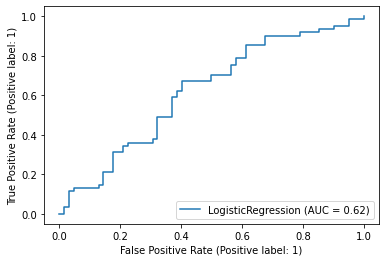

In [60]:
lr_model = LogisticRegression(**best_params_logistic)
lr_model.fit(train_logistic_pp, train_y, sample_weight=train_sw)

lr_train_preds = lr_model.predict(train_logistic_pp)
lr_train_probs = lr_model.predict_proba(train_logistic_pp)[:, 1]
lr_train_preds_prob = [1 if p >= 0.4 else 0 for p in lr_train_probs]

lr_test_preds = lr_model.predict(test_logistic_pp)
lr_test_probs = lr_model.predict_proba(test_logistic_pp)[:, 1]
lr_test_preds_prob = [1 if p >= 0.4 else 0 for p in lr_test_probs]


print('Train Metrics:')
print_results(train_y, lr_train_preds_prob, lr_train_probs)
print('\n\nTest Metrics:')
lr_acc, lr_f1, lr_auc, lr_recall = print_results(test_y, lr_test_preds_prob, lr_test_probs, lr_model, test_logistic_pp)

## Model Explainability

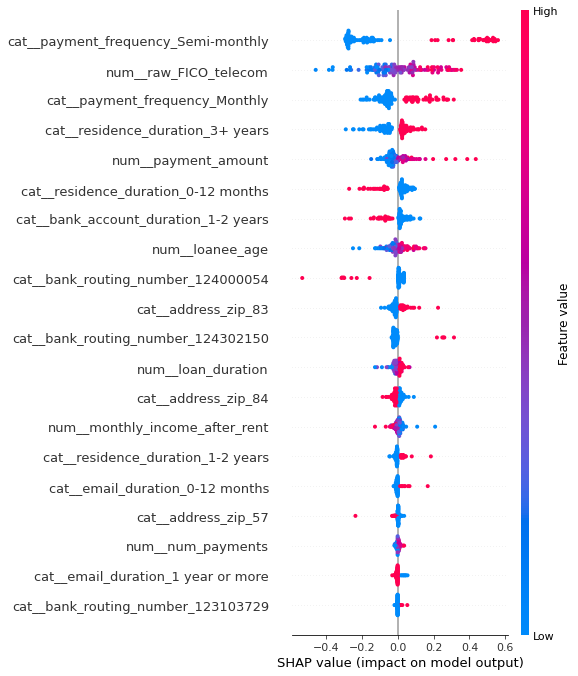

In [61]:
explainer = shap.Explainer(lr_model.predict, test_logistic_pp)
shap_values = np.array(explainer.shap_values(test_logistic_pp))
shap.summary_plot(shap_values, pd.DataFrame(test_logistic_pp, columns=logistic_use_feats))

## RandomForest

In [62]:
def rf_objective(trial, X, y, cvs, base_params, sample_weight):
    
    # Setup values for the hyperparameters:
    hp_grid = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 4, 12),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 150),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
        }
    
    clf = RandomForestClassifier(**hp_grid, **base_params)

    # Step 3: Scoring method:
    score = cross_val_score(clf, X, y, n_jobs=-1, cv=cvs, scoring='recall', fit_params={'sample_weight': sample_weight})
    average_acc = score.mean()
    return average_acc

train_rf_pp = train_pp
test_rf_pp = test_pp        
        
base_params_rf = {"random_state": 1}

study = create_study(pruner=HyperbandPruner(reduction_factor=2), sampler=TPESampler(n_startup_trials=20, seed=2), 
                     direction="maximize", study_name='rf_hp_tuning')
study.optimize(lambda trial: rf_objective(trial, train_rf_pp, train_y, train_tcvs, base_params_rf, train_sw), 
               n_trials=50, callbacks=[partial(early_stopping_check, early_stopping_rounds=10),
                                       MaxTrialsCallback(100, states=(TrialState.COMPLETE,))])

best_params_rf = study.best_trial.params
print(f'Best Params: {best_params_rf}')
best_params_rf.update({**base_params_rf})

Best Params: {'n_estimators': 98, 'max_depth': 11, 'min_samples_split': 19, 'min_samples_leaf': 2}


Train Metrics:
Accuracy: 0.8571428571428571
F1-Score: 0.8548057259713702
AUC Score: 0.9616943455911428
Recall: 0.9675925925925926


Test Metrics:
Accuracy: 0.6178861788617886
F1-Score: 0.6758620689655173
AUC Score: 0.6845584346906398
Recall: 0.8032786885245902


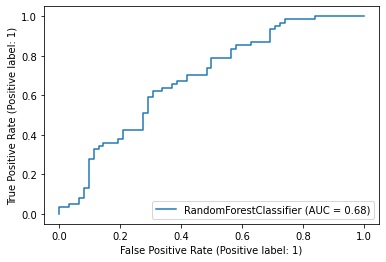

In [63]:
rf_model = RandomForestClassifier(**best_params_rf)
rf_model.fit(train_rf_pp, train_y, sample_weight=train_sw)

rf_train_preds = rf_model.predict(train_rf_pp)
rf_train_probs = rf_model.predict_proba(train_rf_pp)[:, 1]
rf_train_preds_prob = [1 if p >= 0.4 else 0 for p in rf_train_probs]


rf_test_preds = rf_model.predict(test_rf_pp)
rf_test_probs = rf_model.predict_proba(test_rf_pp)[:, 1]
rf_test_preds_prob = [1 if p >= 0.4 else 0 for p in rf_test_probs]
# Different clients can assume different levels of Type2 risk, can modulate this via threshold levl


print('Train Metrics:')
print_results(train_y, rf_train_preds_prob, rf_train_probs)
print('\n\nTest Metrics:')
rf_acc, rf_f1, rf_auc, rf_recall = print_results(test_y, rf_test_preds_prob, rf_test_probs, rf_model, test_rf_pp)

### Model Explainability

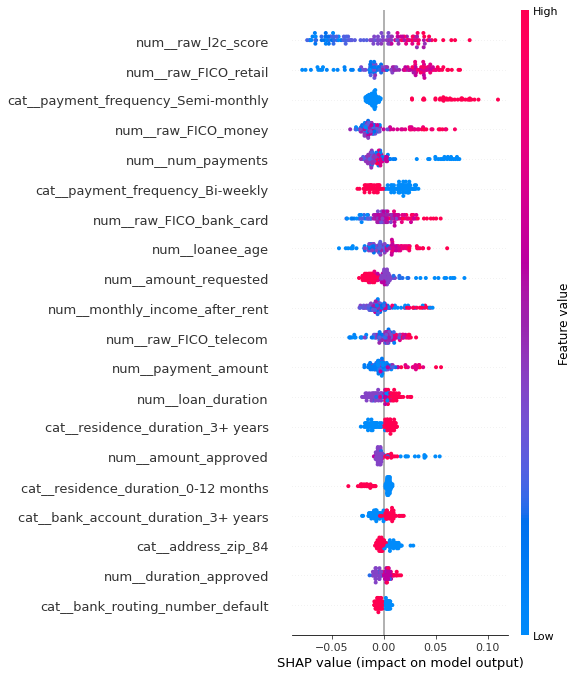

In [64]:
explainer = shap.Explainer(rf_model)
shap_values = np.array(explainer.shap_values(test_rf_pp))
shap.summary_plot(shap_values[1], pd.DataFrame(test_rf_pp, columns=preproc_out_feats))

## XGBoost

### Hyper-parameter Tuning

In [65]:
def xgb_objective(trial, X, y, cvs, base_params, sample_weight):
    
    # Setup values for the hyperparameters:
    hp_grid = {"booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
               "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
               "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
               "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50)}

    if hp_grid["booster"] in ["gbtree", "dart"]:
        hp_grid["max_depth"] = trial.suggest_int("max_depth", 1, 7)
        hp_grid["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        hp_grid["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        hp_grid["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if hp_grid["booster"] == "dart":
        hp_grid["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        hp_grid["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        hp_grid["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        hp_grid["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    
    clf = XGBClassifier(**hp_grid, **base_params)

    # Step 3: Scoring method:
    score = cross_val_score(clf, X, y, n_jobs=-1, cv=cvs, scoring='f1', fit_params={'sample_weight': sample_weight})
    average_acc = score.mean()
    return average_acc

train_xgb_pp = train_pp
test_xgb_pp = test_pp        
        
base_params_xgb = {"objective": "binary:logistic", "verbosity": 0, "random_state": 1}

study = create_study(pruner=HyperbandPruner(reduction_factor=2), sampler=TPESampler(n_startup_trials=20, seed=2), 
                     direction="maximize", study_name='xgboost_hp_tuning')
study.optimize(lambda trial: xgb_objective(trial, train_xgb_pp, train_y, train_tcvs, base_params_xgb, train_sw), 
               n_trials=50, callbacks=[partial(early_stopping_check, early_stopping_rounds=10),
                                       MaxTrialsCallback(100, states=(TrialState.COMPLETE,))])

best_params_xgb = study.best_trial.params
print(f'Best Params: {best_params_xgb}')
best_params_xgb.update({**base_params_xgb})

Best Params: {'booster': 'dart', 'lambda': 1.3195240310678462e-08, 'alpha': 2.2781983645806513e-06, 'n_estimators': 400, 'max_depth': 1, 'eta': 0.13090701285954356, 'gamma': 0.8560804526399561, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.428644473771179e-05, 'skip_drop': 1.1292626245131823e-05}


Train Metrics:
Accuracy: 0.704225352112676
F1-Score: 0.7189292543021032
AUC Score: 0.8585738763674707
Recall: 0.8703703703703703


Test Metrics:
Accuracy: 0.6504065040650406
F1-Score: 0.7074829931972788
AUC Score: 0.6975145425700687
Recall: 0.8524590163934426


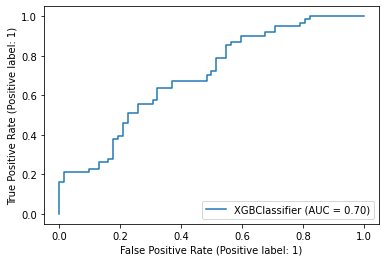

In [66]:
xgb_model = XGBClassifier(**best_params_xgb)
xgb_model.fit(train_xgb_pp, train_y, sample_weight=train_sw)

xgb_train_preds = xgb_model.predict(train_xgb_pp)
xgb_train_probs = xgb_model.predict_proba(train_xgb_pp)[:, 1]
xgb_train_preds_prob = [1 if p >= 0.36 else 0 for p in xgb_train_probs]


xgb_test_preds = xgb_model.predict(test_xgb_pp)
xgb_test_probs = xgb_model.predict_proba(test_xgb_pp)[:, 1]
xgb_test_preds_prob = [1 if p >= 0.36 else 0 for p in xgb_test_probs]


print('Train Metrics:')
print_results(train_y, xgb_train_preds_prob, xgb_train_probs)
print('\n\nTest Metrics:')
xgb_acc, xgb_f1, xgb_auc, xgb_recall = print_results(test_y, xgb_test_preds_prob, xgb_test_probs, xgb_model, test_xgb_pp)

In [67]:
pd.DataFrame([[0.704, 0.650], [0.719, 0.707], [0.859, 0.698], [0.870, 0.852]], columns = ['Training Data', 'Testing Data'],
            index = ['Accuracy', 'F1-Score', 'AUC Score', 'Recall'])

,Training Data,Testing Data
Accuracy,0.704,0.650
F1-Score,0.719,0.707
AUC Score,0.859,0.698
Recall,0.870,0.852


### Model Explainability

In [68]:
xgb_feat_imp = pd.DataFrame(xgb_model.feature_importances_, index=preproc_out_feats, 
             columns=['importance']).sort_values('importance', ascending=False)

Permutation explainer: 124it [02:40,  1.37s/it]                                 


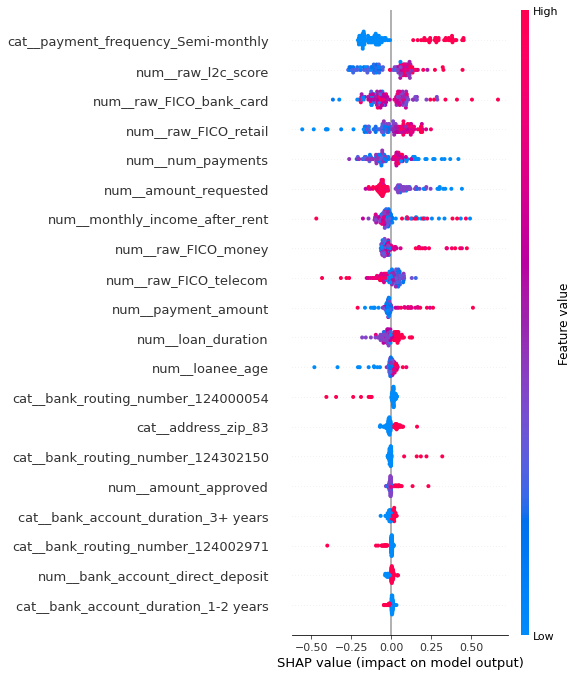

In [69]:
explainer = shap.Explainer(xgb_model.predict, test_xgb_pp)
shap_values = explainer.shap_values(test_xgb_pp, silent=True)
shap.summary_plot(shap_values, pd.DataFrame(test_xgb_pp, columns=preproc_out_feats),show=False)
plt.savefig('XGBoost_SHAP_plot.png',dpi=700)
plt.show()

# Model Comparison

In [70]:
print(f"Accuracy LR:  {lr_acc}")
print(f"Accuracy RF:  {rf_acc}")
print(f"Accuracy XGB: {xgb_acc}\n")

print(f"F1-Score LR:  {lr_f1}")
print(f"F1-Score RF:  {rf_f1}")
print(f"F1-Score XGB: {xgb_f1}\n")

print(f"Recall LR:  {lr_recall}")
print(f"Recall RF:  {rf_recall}")
print(f"Recall XGB: {xgb_recall}\n")

Accuracy LR:  0.6016260162601627
Accuracy RF:  0.6178861788617886
Accuracy XGB: 0.6504065040650406

F1-Score LR:  0.6711409395973155
F1-Score RF:  0.6758620689655173
F1-Score XGB: 0.7074829931972788

Recall LR:  0.819672131147541
Recall RF:  0.8032786885245902
Recall XGB: 0.8524590163934426



In [71]:
pd.DataFrame([[lr_acc, rf_acc, xgb_acc], [lr_f1, rf_f1, xgb_f1],[lr_recall, rf_recall, xgb_recall]], index=['Accuracy', 'F1-Score', 'Recall'], 
             columns=['Logistic Regression', 'Random Forest', 'XGBoost'])

,Logistic Regression,Random Forest,XGBoost
Accuracy,0.601626,0.617886,0.650407
F1-Score,0.671141,0.675862,0.707483
Recall,0.819672,0.803279,0.852459


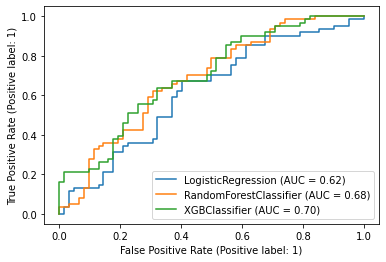

In [72]:
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(lr_model, test_logistic_pp, test_y, ax = ax)
RocCurveDisplay.from_estimator(rf_model, test_rf_pp, test_y, ax = ax)
RocCurveDisplay.from_estimator(xgb_model, test_xgb_pp, test_y, ax = ax)
ax.figure.savefig('ROC_AUC_curve.png', dpi=300)

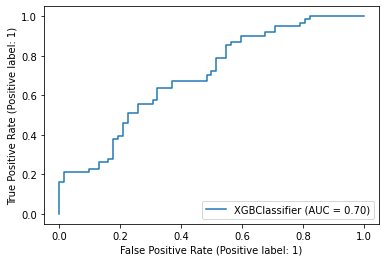

In [73]:
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(xgb_model, test_xgb_pp, test_y, ax = ax)
ax.figure.savefig('XGBoost_ROC_AUC_curve.png', dpi=300)